In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [88]:
df_original = pd.read_csv('supermarket_sales.csv')

df = df_original.copy()

Brief overview:

In [89]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Total                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross margin percentage  

Renaming cols for easier access:

In [90]:
df_original.columns = df_original.columns.str.lower().str.replace(' ', '_')

Creating a copy of the original data to use throughout the assignment:

In [91]:
df = df_original.copy()

Step 1: Understanding the domain matter:

From the data provided, we're looking to predict the quantity of products purchased, which could be useful in stock management, prediction of sales, etc.

Step 2: Verifying the data is in the correct format:

Let's check the data types of each column:

In [92]:
df.dtypes

invoice_id                  object
branch                      object
city                        object
customer_type               object
gender                      object
product_line                object
unit_price                 float64
quantity                     int64
tax_5%                     float64
total                      float64
date                        object
time                        object
payment                     object
cogs                       float64
gross_margin_percentage    float64
gross_income               float64
rating                     float64
dtype: object

Ensure date and time column is in datetime format:

In [93]:
df['date'] = pd.to_datetime(df['date'])
df['time'] = pd.to_datetime(df['time'], format="%H:%M")


In order to 

Check for missing values:

In [94]:
df.isnull().sum()

invoice_id                 0
branch                     0
city                       0
customer_type              0
gender                     0
product_line               0
unit_price                 0
quantity                   0
tax_5%                     0
total                      0
date                       0
time                       0
payment                    0
cogs                       0
gross_margin_percentage    0
gross_income               0
rating                     0
dtype: int64

Check for duplicates:

In [95]:
df.duplicated().sum()

0

Step 3: Univariate data analysis:

Let us describe the numerical vars:

In [96]:
df.describe()

,unit_price,quantity,tax_5%,total,cogs,gross_margin_percentage,gross_income,rating
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1.000000e+03,1000.000000,1000.00000
mean,55.672130,5.510000,15.379369,322.966749,307.58738,4.761905e+00,15.379369,6.97270
std,26.494628,2.923431,11.708825,245.885335,234.17651,6.131498e-14,11.708825,1.71858
min,10.080000,1.000000,0.508500,10.678500,10.17000,4.761905e+00,0.508500,4.00000
25%,32.875000,3.000000,5.924875,124.422375,118.49750,4.761905e+00,5.924875,5.50000
50%,55.230000,5.000000,12.088000,253.848000,241.76000,4.761905e+00,12.088000,7.00000
75%,77.935000,8.000000,22.445250,471.350250,448.90500,4.761905e+00,22.445250,8.50000
max,99.960000,10.000000,49.650000,1042.650000,993.00000,4.761905e+00,49.650000,10.00000


And for categorical variables:



In [97]:
for col in df.select_dtypes(include='object').columns:
    print(f"\nColumn Name: {col}")
    print(df[col].value_counts())



Column Name: invoice_id
750-67-8428    1
642-61-4706    1
816-72-8853    1
491-38-3499    1
322-02-2271    1
              ..
633-09-3463    1
374-17-3652    1
378-07-7001    1
433-75-6987    1
849-09-3807    1
Name: invoice_id, Length: 1000, dtype: int64

Column Name: branch
A    340
B    332
C    328
Name: branch, dtype: int64

Column Name: city
Yangon       340
Mandalay     332
Naypyitaw    328
Name: city, dtype: int64

Column Name: customer_type
Member    501
Normal    499
Name: customer_type, dtype: int64

Column Name: gender
Female    501
Male      499
Name: gender, dtype: int64

Column Name: product_line
Fashion accessories       178
Food and beverages        174
Electronic accessories    170
Sports and travel         166
Home and lifestyle        160
Health and beauty         152
Name: product_line, dtype: int64

Column Name: payment
Ewallet        345
Cash           344
Credit card    311
Name: payment, dtype: int64


Finding multicollinearity:

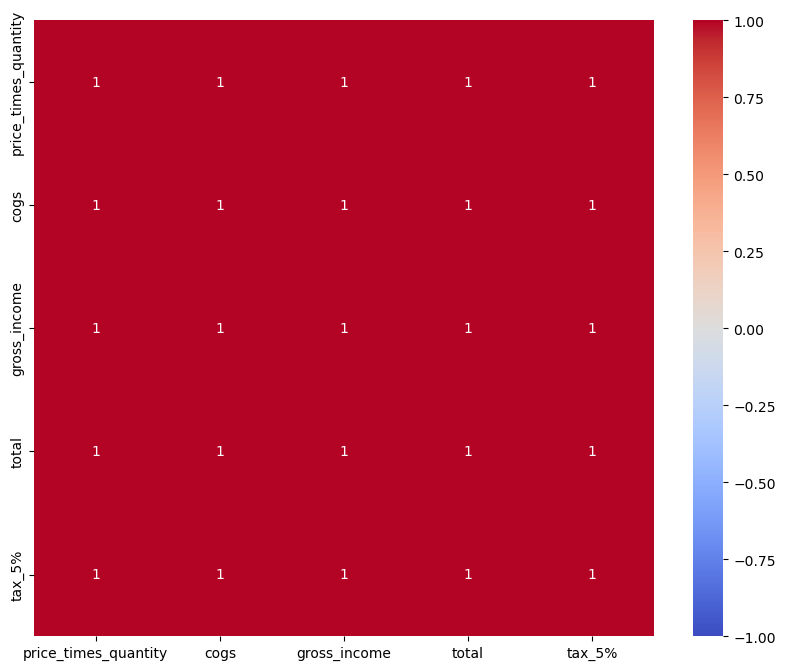

In [98]:
price_times_quantity = pd.Series(df['unit_price'] * df['quantity'], name="price_times_quantity")

# Correlation
correlation = pd.concat([price_times_quantity, df['cogs'], df['gross_income'], df['total'], df['tax_5%']], axis=1).corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()


Cogs, gross income, tota, tax_5% are all captured by quantity and price, so we remove them:

In [99]:
df.drop(columns=['cogs', 'gross_income', 'tax_5%','total'], inplace = True)

We also delete gross_margin_percentage because it is constant:

In [100]:
df.gross_margin_percentage.value_counts()

4.761905    1000
Name: gross_margin_percentage, dtype: int64

In [101]:
df.drop(columns=['gross_margin_percentage'], inplace=True)

Let us convert dates and time so that it works with our models:

In [102]:
df['day_of_week'] = df['date'].dt.dayofweek
df['hour'] = df['time'].dt.hour

df.drop(columns=['date', 'time'], inplace=True)

We drop invoice_id because it appears secondary:

In [103]:
df.drop(columns=['invoice_id'], inplace=True)

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   branch         1000 non-null   object 
 1   city           1000 non-null   object 
 2   customer_type  1000 non-null   object 
 3   gender         1000 non-null   object 
 4   product_line   1000 non-null   object 
 5   unit_price     1000 non-null   float64
 6   quantity       1000 non-null   int64  
 7   payment        1000 non-null   object 
 8   rating         1000 non-null   float64
 9   day_of_week    1000 non-null   int64  
 10  hour           1000 non-null   int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 86.1+ KB


In [107]:
X = df.drop('quantity', axis=1)  # all columns except 'quantity'
y = df['quantity']  # target column


In [127]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

def train_ridge(data, target_variable, test_size=0.2):
    # Preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['unit_price', 'rating', 'day_of_week', 'hour']),
            ('cat', OneHotEncoder(), ['branch', 'city', 'customer_type', 'gender', 'product_line', 'payment'])
        ])

    # Define pipeline
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', Ridge())
    ])

    # Split data
    X = data.drop(target_variable, axis=1)  
    y = data[target_variable]  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

    # Hyperparameter tuning
    alpha_values = [10**i for i in range(-10,2)]
    training_scores = []
    validation_scores = []
    best_model = None
    best_rmse_val = float('inf')

    for alpha in tqdm(alpha_values):
        model.set_params(classifier__alpha=alpha)  # setting the 'alpha' for Ridge inside the pipeline
        model.fit(X_train, y_train)

        train_prediction = model.predict(X_train).clip(0,20)
        val_prediction = model.predict(X_test).clip(0,20)

        rmse_train = mean_squared_error(train_prediction, y_train, squared=False)
        rmse_val = mean_squared_error(val_prediction, y_test, squared=False)

        if best_rmse_val > rmse_val:
            best_model = model
            best_rmse_val = rmse_val

        training_scores.append(rmse_train)
        validation_scores.append(rmse_val)

    ridge_log = (training_scores, validation_scores, alpha_values)

    return best_model, ridge_log


In [128]:
best_model, ridge_log = train_ridge(df, 'quantity')


100%|██████████| 12/12 [00:00<00:00, 74.42it/s]


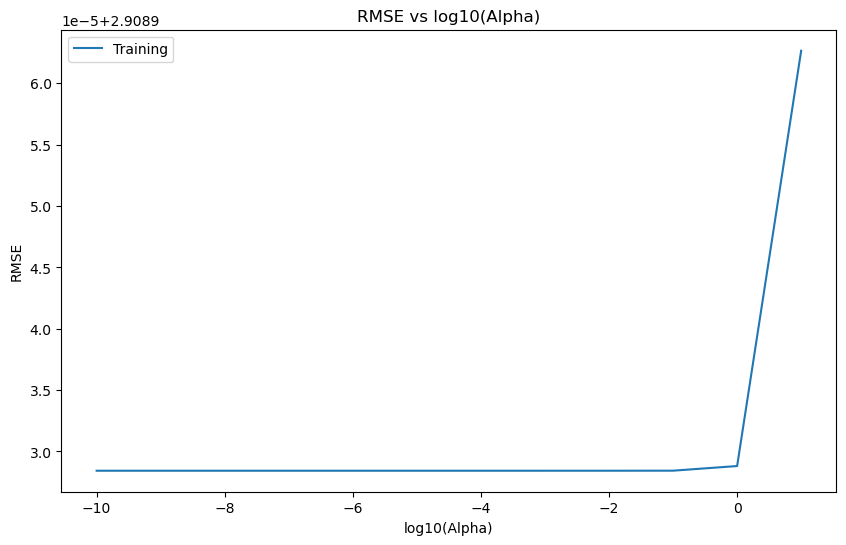

In [129]:
import matplotlib.pyplot as plt

# Training and validation scores
training_scores, validation_scores, alpha_values = ridge_log

# Convert alpha_values to logarithmic scale for a better visualization
log_alphas = [np.log10(alpha) for alpha in alpha_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(log_alphas, training_scores, label='Training')

plt.xlabel('log10(Alpha)')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE vs log10(Alpha)')
plt.show()

In [130]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['unit_price', 'rating',
                                                   'day_of_week', 'hour']),
                                                 ('cat', OneHotEncoder(),
                                                  ['branch', 'city',
                                                   'customer_type', 'gender',
                                                   'product_line',
                                                   'payment'])])),
                ('classifier', Ridge(alpha=10))])